# L, epsilon, and other tweaking

##### Keywords: energy, hamiltonian monte carlo, NUTS, leapfrog, canonical distribution, microcanonical distribution, transition distribution, marginal energy distribution, data augmentation, classical mechanics, detailed balance, statistical mechanics, divergences, step-size, non-centered hierarchical model, hierarchical

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

## Centered parametrization

We'll set up the modelled in what is called a "Centered" parametrization which tells us how $\theta_i$ is modelled: it is written to be directly dependent as a normal distribution from the hyper-parameters. 

In [7]:
J = 8
y = np.array([28,  8, -3,  7, -1,  1, 18, 12])
sigma = np.array([15, 10, 16, 11,  9, 11, 10, 18])

We set up our priors in a Hierarchical model to use this centered parametrization. We can say: the $\theta_j$ is drawn from a Normal hyper-prior distribution with parameters $\mu$ and $\tau$. Once we get a $\theta_j$ then can draw the means from it given the data $\sigma_j$ and one such draw corresponds to our data.

$$
\mu \sim \mathcal{N}(0, 5)\\
\tau \sim \text{Half-Cauchy}(0, 5)\\
\theta_{j} \sim \mathcal{N}(\mu, \tau)\\
\bar{y_{j}} \sim \mathcal{N}(\theta_{j}, \sigma_{j})
$$

where $j \in \{1, \ldots, 8 \}$ and the
$\{ y_{j}, \sigma_{j} \}$ are given as data

In [8]:
with pm.Model() as schools1:

    mu = pm.Normal('mu', 0, sd=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta = pm.Normal('theta', mu=mu, sd=tau, shape=J)
    obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)

In [9]:
with schools1:
    trace1 = pm.sample(5000, init=None, njobs=2, tune=1000)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, tau_log__, mu]
100%|██████████| 6000/6000 [00:11<00:00, 509.61it/s]
There were 914 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.445177634049, but should be close to 0.8. Try to increase the number of tuning steps.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.71464739587, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [13]:
pm.diagnostics.gelman_rubin(trace1), pm.diagnostics.effective_n(trace1)

({'mu': 1.0214138101971797,
  'tau': 1.0890758192035539,
  'theta': array([ 1.00109614,  1.00574629,  1.01928611,  1.01160475,  1.03728323,
          1.01563653,  1.00039723,  1.00409768])},
 {'mu': 30.0,
  'tau': 9.0,
  'theta': array([ 1826.,  1694.,    37.,   220.,    25.,    36.,  1430.,  2591.])})

The Gelman-Rubin statistic seems fine, but notice how small the effective-n's are? Something is not quite right. Lets see traceplots.

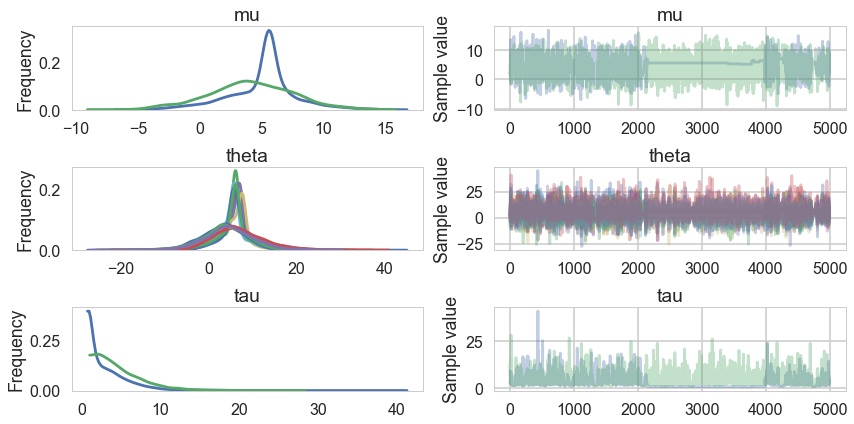

In [14]:
pm.traceplot(trace1);

Its hard to pick the thetas out but $\tau$ looks not so white-noisy. Lets zoom in:

In [15]:
trace1.varnames

['mu', 'tau_log__', 'theta', 'tau']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1192ec438>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1185e6470>]], dtype=object)

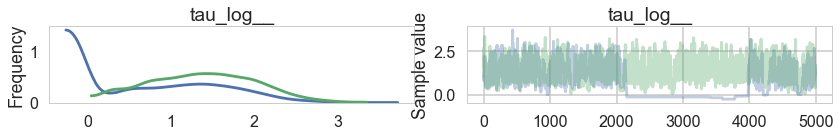

In [16]:
pm.traceplot(trace1, varnames=['tau_log__'])

There seems to be some stickiness at lower values in the trace. Zooming in even more helps us see this better:

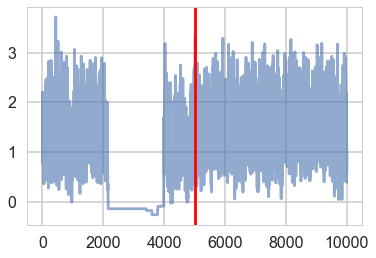

In [17]:
plt.plot(trace1['tau_log__'], alpha=0.6)
plt.axvline(5000, color="r")
#plt.plot(short_trace['tau_log_'][5000:], alpha=0.6);

### Tracking divergences

In [18]:
divergent = trace1['diverging']
divergent

array([False, False, False, ..., False, False, False], dtype=bool)

In [19]:
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size/len(trace1)
print('Percentage of Divergent %.5f' % divperc)

Number of Divergent 1002
Percentage of Divergent 0.20040


In [20]:
def biasplot(trace):
    logtau = trace['tau_log__']
    mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
    plt.figure(figsize=(8, 2))
    plt.axhline(0.7657852, lw=2.5, color='gray')
    plt.plot(mlogtau, lw=2.5)
    plt.ylim(0, 2)
    plt.xlabel('Iteration')
    plt.ylabel('MCMC mean of log(tau)')
    plt.title('MCMC estimation of cumsum log(tau)')

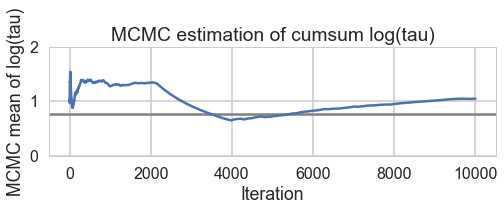

In [21]:
biasplot(trace1)

In [22]:
def funnelplot(trace):
    logtau = trace['tau_log__']
    divergent = trace['diverging']
    theta_trace = trace['theta']
    theta0 = theta_trace[:, 0]
    plt.figure(figsize=(5, 3))
    plt.scatter(theta0[divergent == 0], logtau[divergent == 0], s=10, color='r', alpha=0.1)
    plt.scatter(theta0[divergent == 1], logtau[divergent == 1], s=10, color='g')
    plt.axis([-20, 50, -6, 4])
    plt.ylabel('log(tau)')
    plt.xlabel('theta[0]')
    plt.title('scatter plot between log(tau) and theta[0]')
    plt.show()

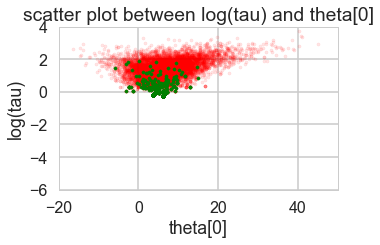

In [23]:
funnelplot(trace1)

You can also get an idea of your acceptance rate. 65% is decent for NUTS.

In [24]:
np.mean(trace1['mean_tree_accept'])

0.57991251495943541

### Where are the divergences coming from?

Divergences can be a sign of the symplectic integration going off to infinity, or a false positive. False positives occur because instead of waiting for infinity, some heuristics are used. This is typically true of divergences not deep in the funnel, where the curvature of the target distribution is high.





## The effect of step-size

Looking at the docs for the `NUTS` sampler at https://pymc-devs.github.io/pymc3/api/inference.html#module-pymc3.step_methods.hmc.nuts , we see that we can co-erce a smaller step-size $\epsilon$, and thus an ok symplectic integration from our sampler by increasing the target acceptance rate.

If we do this, then we have geometric ergodicity (we go everywhere!) between the Hamiltonian transitions (ie in the leapfrogs) and the target distribution. This should result in the divergence rate decreasing.

But if for some reason we do not have geometric ergodicity, then divergences will persist. This can happen deep in the funnel, where even drastic decreases in the step size are not able to explore the highly curved geometry.


In [25]:
with schools1:
    step = pm.NUTS(target_accept=.85)
    trace1_85 = pm.sample(5000, step=step, init=None, njobs=2, tune=1000)
with schools1:
    step = pm.NUTS(target_accept=.90)
    trace1_90 = pm.sample(5000, step=step, init=None, njobs=2, tune=1000)
with schools1:
    step = pm.NUTS(target_accept=.95)
    trace1_95 = pm.sample(5000, step=step, init=None, njobs=2, tune=1000)
with schools1:
    step = pm.NUTS(target_accept=.99)
    trace1_99 = pm.sample(5000, step=step, init=None, njobs=2, tune=1000)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, tau_log__, mu]
100%|██████████| 6000/6000 [00:16<00:00, 363.88it/s]
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.718139302733, but should be close to 0.85. Try to increase the number of tuning steps.
There were 245 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7030685137, but should be close to 0.85. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, tau_log__, mu]
100%|██████████| 6000/6000 [00:21<00:00, 284.50it/s]
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
There were 156 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match 

In [26]:
for t in [trace1_85, trace1_90, trace1_95, trace1_99]:
    print("Acceptance", np.mean(t['mean_tree_accept']), "Step Size", np.mean(t['step_size']), "Divergence", np.sum(t['diverging']))

Acceptance 0.710603908216 Step Size 0.320560550265 Divergence 403
Acceptance 0.780963159621 Step Size 0.239954261044 Divergence 232
Acceptance 0.870649437743 Step Size 0.174223895957 Divergence 254
Acceptance 0.957912073924 Step Size 0.0766605241909 Divergence 45


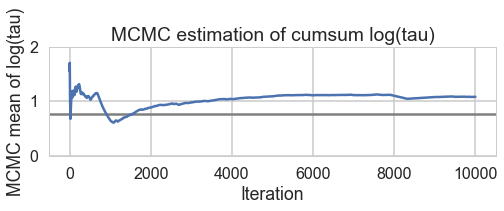

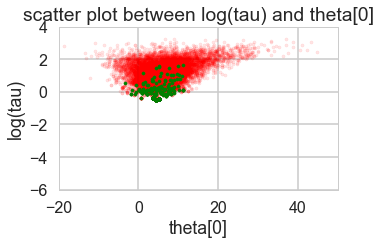

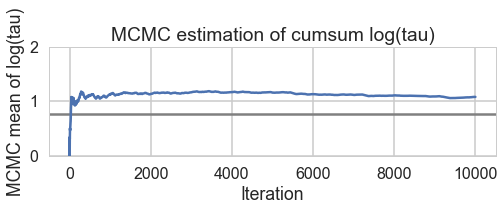

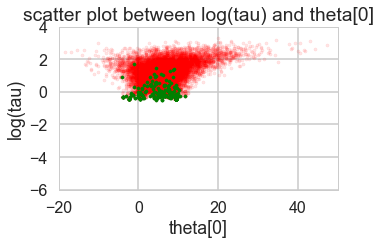

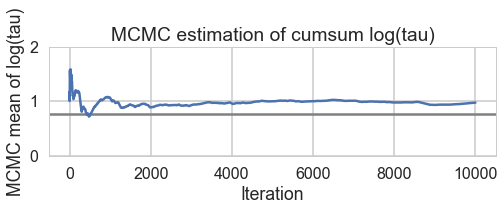

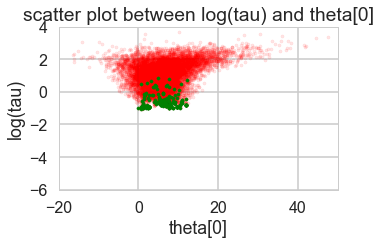

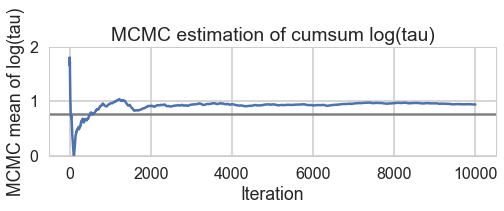

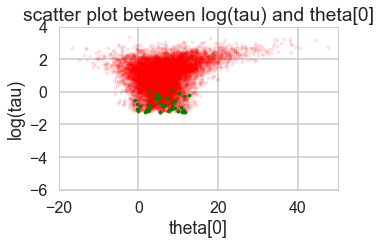

In [27]:
for t in [trace1_85, trace1_90, trace1_95, trace1_99]:
    biasplot(t)
    funnelplot(t)

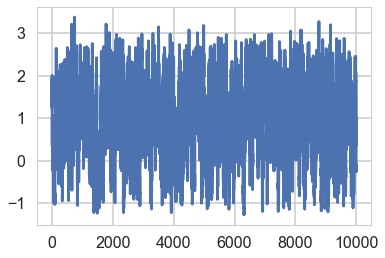

In [28]:
plt.plot(trace1_99['tau_log__'])

In [43]:
df99 = pm.trace_to_dataframe(trace1_99)
df99.head()

,mu,theta__0,theta__1,theta__2,theta__3,theta__4,theta__5,theta__6,theta__7,tau
0,0.476766,5.244940,11.947961,-2.145423,-4.379043,-2.582646,-6.725088,0.876145,1.316700,5.273161
1,4.609032,12.076996,-7.616970,6.384172,5.940715,3.010732,13.464991,3.902260,-2.996996,6.836384
2,3.430340,10.423970,-0.889389,7.728908,8.366453,5.533233,15.195454,5.423708,5.681029,6.246578
3,3.950691,3.769489,-2.915153,4.353163,-3.110655,2.558563,-3.668601,7.396706,3.781000,3.469858
4,1.124394,8.179717,11.401375,13.333014,4.985015,-2.360172,3.140696,7.872551,1.341216,6.758684


In [44]:
df99.corr()

,mu,theta__0,theta__1,theta__2,theta__3,theta__4,theta__5,theta__6,theta__7,tau
mu,1.000000,0.496149,0.575298,0.605714,0.605968,0.617708,0.600656,0.507750,0.559291,-0.137465
theta__0,0.496149,1.000000,0.354088,0.268464,0.340208,0.229898,0.277801,0.459301,0.356955,0.363872
theta__1,0.575298,0.354088,1.000000,0.329506,0.361995,0.330835,0.359453,0.350181,0.313994,0.061695
theta__2,0.605714,0.268464,0.329506,1.000000,0.376094,0.400555,0.378128,0.265483,0.329640,-0.178865
theta__3,0.605968,0.340208,0.361995,0.376094,1.000000,0.377131,0.393790,0.323031,0.366408,-0.004266
theta__4,0.617708,0.229898,0.330835,0.400555,0.377131,1.000000,0.400101,0.228025,0.324586,-0.277632
theta__5,0.600656,0.277801,0.359453,0.378128,0.393790,0.400101,1.000000,0.251256,0.332723,-0.169251
theta__6,0.507750,0.459301,0.350181,0.265483,0.323031,0.228025,0.251256,1.000000,0.380259,0.379399
theta__7,0.559291,0.356955,0.313994,0.329640,0.366408,0.324586,0.332723,0.380259,1.000000,0.080647
tau,-0.137465,0.363872,0.061695,-0.178865,-0.004266,-0.277632,-0.169251,0.379399,0.080647,1.000000


In [61]:
trace1_99['diverging'].shape, df99.shape

((10000,), (10000, 10))

In [68]:
df99si = df99.reset_index()
df99si.head()

,index,mu,theta__0,theta__1,theta__2,theta__3,theta__4,theta__5,theta__6,theta__7,tau
0,0,0.476766,5.244940,11.947961,-2.145423,-4.379043,-2.582646,-6.725088,0.876145,1.316700,5.273161
1,1,4.609032,12.076996,-7.616970,6.384172,5.940715,3.010732,13.464991,3.902260,-2.996996,6.836384
2,2,3.430340,10.423970,-0.889389,7.728908,8.366453,5.533233,15.195454,5.423708,5.681029,6.246578
3,3,3.950691,3.769489,-2.915153,4.353163,-3.110655,2.558563,-3.668601,7.396706,3.781000,3.469858
4,4,1.124394,8.179717,11.401375,13.333014,4.985015,-2.360172,3.140696,7.872551,1.341216,6.758684


In [90]:
dvs = sum(trace1_99['diverging']==True)

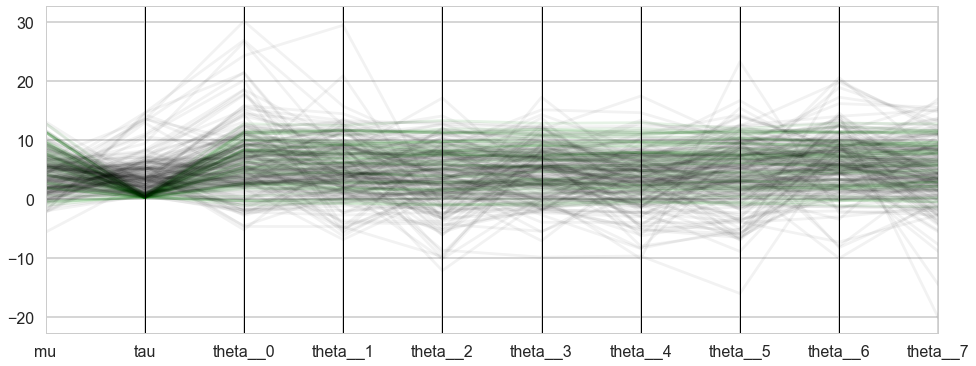

In [95]:
from pandas.plotting import parallel_coordinates as pc
plt.figure(figsize=(16, 6))
orderedticks = ['index', 'mu', 'tau']+["theta__{}".format(i) for i in range(8)]
div_colors = list(islice(cycle(['g', 'g', 'g', 'g', 'g']), None, int(dvs)))
pc(df99si[trace1_99['diverging']==True][orderedticks], 'index', color=div_colors, alpha=0.1);
from itertools import cycle, islice
undiv_colors = list(islice(cycle(['k', 'k', 'k', 'k', 'k']), None, 200))
pc(df99si[trace1_99['diverging']==False].sample(200)[orderedticks], 'index', color=undiv_colors, alpha=0.05);
plt.gca().legend_.remove()

The divergences decrease, but dont totally go away, showing that we have lost some geometric ergodicity. And as we get to a very small step size we explore the funnel much better, but we are now taking our sampler more into a MH like random walk regime, and our sampler looks very strongly autocorrelated.

We know the fix, it is to move to a

## Non-centered paramerization

We change our model to:

$$
\mu \sim \mathcal{N}(0, 5)\\
\tau \sim \text{Half-Cauchy}(0, 5)\\
\nu_{j} \sim \mathcal{N}(0, 1)\\
\theta_{j} = \mu + \tau\nu_j \\
\bar{y_{j}} \sim \mathcal{N}(\theta_{j}, \sigma_{j})
$$

Notice how we have factored the dependency of $\theta$ on $\phi = \mu, \tau$ into a deterministic
transformation between the layers, leaving the
actively sampled variables uncorrelated. 

This does two things for us: it reduces steepness and curvature, making for better stepping. It also reduces the strong change in densities, and makes sampling from the transition distribution easier.

In [29]:
with pm.Model() as schools2:
    mu = pm.Normal('mu', mu=0, sd=5)
    tau = pm.HalfCauchy('tau', beta=5)
    nu = pm.Normal('nu', mu=0, sd=1, shape=J)
    theta = pm.Deterministic('theta', mu + tau * nu)
    obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)

In [30]:
with schools2:
    trace2 = pm.sample(5000, init=None, njobs=2, tune=1000)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau_log__, mu]
100%|██████████| 6000/6000 [00:08<00:00, 693.86it/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


And we reach the true value better as the number of samples increases, decreasing our bias

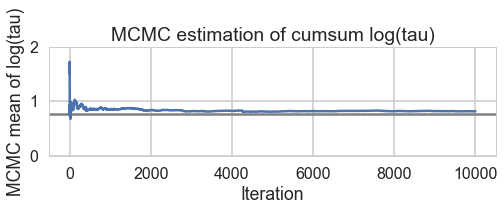

In [31]:
biasplot(trace2)

How about our divergences? They have decreased too.

In [32]:
divergent = trace2['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size/len(trace2)
print('Percentage of Divergent %.5f' % divperc)

Number of Divergent 8
Percentage of Divergent 0.00160


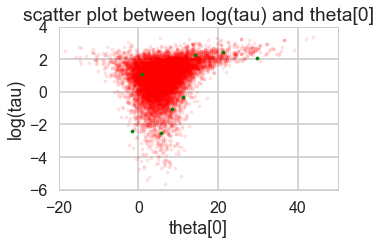

In [33]:
funnelplot(trace2)

The divergences are infrequent and do not seem to concentrate anywhere, indicative of false positives. Lowering the step size should make them go away.

### A smaller step size

In [34]:
with schools2:
    step = pm.NUTS(target_accept=.95)
    trace2_95 = pm.sample(5000, step=step, init=None, njobs=2, tune=1000)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau_log__, mu]
100%|██████████| 6000/6000 [00:13<00:00, 434.59it/s]


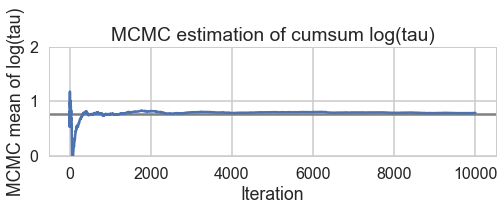

In [35]:
biasplot(trace2_95)

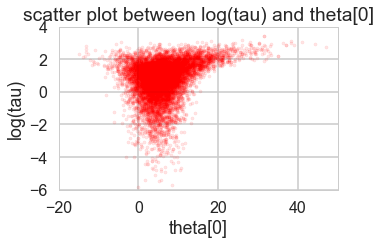

In [36]:
funnelplot(trace2_95)

Indeed at a smaller step-size our false-positive divergences go away, and the lower curvature in our parametrization ensures geometric ergodicity deep in our funnel

## Path length L

If we choose too small a $L$ we are returning our HMC sampler to a random walk. How long must a leapfrog run explore a level set of the Hamiltonian (ie of the canonical distribution $p(p,q)$ beofre we force an accept-reject step and a momentum resample?

Clearly if we go too long we'll be coming back to the neighborhood of areas we might have reached in smaller trajectories. NUTS is one approach to adaptively fix this by not letting trajectories turn on themselves.

In the regular HMC sampler, for slightly complex problems, $L=100$ maybe a good place to start. For a fixed step-size $\epsilon$, we can now check the level of autocorrelation. If it is too much, we want a larger $L$.

Now, the problem with a fixed $L$ is that one $L$ does not work everywhere in a distribution. To see this, note that tails correspond to much higher energies. Thus the level-set surfaces are larger, and a fixed length $L$ trajectory only explores a small portion of this set before a momentum resampling takes us off. This is why a dynamic method like NUTS is a better choice.

## Tuning HMC(NUTS)

This requires preliminary runs. In `pymc3` some samples are dedicated to this, and an adaptive tuning is carried out according to algorithm 6 in the original NUTS paper: http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf .

But we have seem how to play with step-size within the context of the NUTS sampler, something which we might need to do for tetchy models. Clearly too large an $\epsilon$ can lead to loss of symplecticity. And too small a step-size will get us to a random walk for finite sized $L$. Clearly the adaptive approach in NUTS is a good idea.

In pymc3's regular HMC sampler a knob `step_rand` is available which allows us a distribution to sample a step-size from. In the case that we are not adaptively tuning as in NUTS, allowing for this randomness allows for occasionally small values of $\epsilon$ even for large meaned distributions. Note that this should be done at the star of leapfrog, not in-between.

Another place where this is useful is where the exact solution to the Hamiltonian equations (gaussian distribution, harmonic oscillator hamiltonian resulting) has periodicity. If $L\epsilon$ is chosen to be $2\pi$ then our sampler will lack ergodicity. In such a case choose $\epsilon$ from a distribution (or for that matter, $L$).

Finally there are multiple ways to tweak the mass matrix. One might use a variational posterior to obtain a approximate covariance matrix for the target distribution $p(q)$. Or one could use the tuning samples for this purpose. But choosing the mass matrix as the inverse of the covariance matrix of the target is highly recommended, as it will maximally decorrelate parameters of the target distribution.

The covariance matrix also establishes a scale for each parameter. This scale can be used to tweak step size as well. Intuitively the variances are measures of curvature along a particular dimension, and choosing a stepsize in each parameter which accomodates this difference is likely to help symplecticity. I do not believe this optimization is available within pymc3. This does not mean you are out of luck: you could simply redefine the parameters in a scaled form.

If you are combining HMC with other samplers, such as MH for discrete parameters in a gibbs based conditional scheme, then you might prefer smaller $L$ parameters to allow for the other parameters to be updated faster.


## Efficiency of momentum resampling

When we talked about the most Hamiltonian-trajectory momentum resampling, we talked about its efficiency. The point there was that you want the marginal energy distribution to match the transition distribution induced by momentum resampling.

`pymc3` gives us some handy stats to calculate this:

In [38]:
def resample_plot(t):
    sns.distplot(t['energy']-t['energy'].mean(), label="P(E)")
    sns.distplot(np.diff(t['energy']), label = "p(E | q)")
    plt.legend();
    plt.xlabel("E - <E>")
    

So let us see this for our original trace

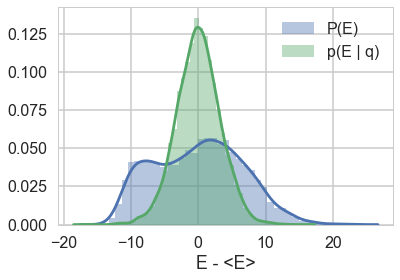

In [39]:
resample_plot(trace1);

Awful. The momentum resamples here will do a very slow job of traversing this distribution. This is indicative of the second issue we were having with this centered model (the first was a large step size for the curvature causing loss of symplectivity): the momentum resampling simply cannot provide enough energy to traverse the large energy changes that occur in this hierarchical model.

Note the caveat with such a plot obtained from our chains: it only tells us about the energies it explored: not the energies it ought to be exploring, as can be seen in the plot with `trace1_99` below. Still, a great diagnostic.

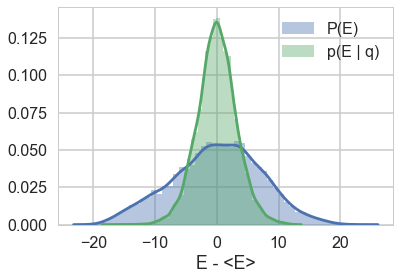

In [40]:
resample_plot(trace1_99)

The match is much better for the non-centered version of our model.

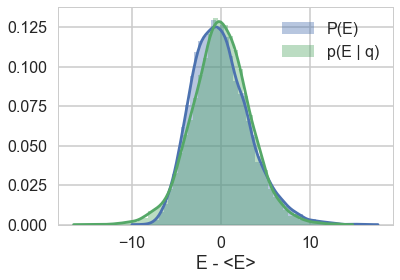

In [41]:
resample_plot(trace2)

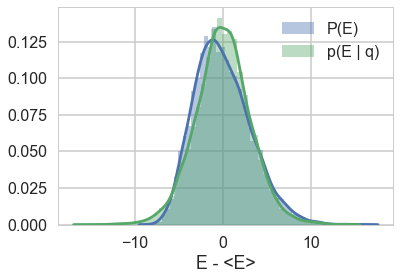

In [42]:
resample_plot(trace2_95)